# Terminal commands for data access

```
autossh -AtX vschuma@ssh1.mdc-berlin.de ssh vschuma@murphy.mdc-berlin.net
# open the ssh screen and/or type
ssh -NR 6667:localhost:22 vfs@79.197.179.128 (current network ID)

# mount
sshfs -p 6667 vschuma@localhost:/data/local/rajewsky/home/vschuma /mnt/murphy_workspace/
or
sshfs vschuma@murphy:/data/local/rajewsky/home/vschuma/ ~/mounts/murphy_workspace/

# if working with the mount is to slow, copy the data to a ramdisk
sudo mount -t tmpfs -o size=6g tmpfs /mnt/ramdisk/

# then copy the file to the ramdisk
mkdir /mnt/ramdisk/data && rsync -av /mnt/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /mnt/ramdisk/data
or
mkdir /dev/shm/data && rsync -av /home/vschuma/mounts/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /dev/shm/data/
# symlink inside the pycharm project to the data dir
(example command)
ln -s /mnt/ramdisk/data data
e.g.: ln -s /mnt/murphy_workspace/NSTT/data/ data
or
ln -s /dev/shm/data/ data
```

# Imports

In [2]:
from importlib import reload

import anndata
from bokeh.layouts import column
%matplotlib inline
import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import zscore
from sklearn import preprocessing

import random

# Notebook location

In [4]:
os.getcwd()

'/home/vfs/PycharmProjects/rajewskyLab/novosparc/Vic/development'

# Data read in

I use the mouse brain data set used in [this squidpy tutorial](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_visium_hne.html#sphx-glr-auto-tutorials-tutorial-visium-hne-py).
The preprocessing (atlas creation, dge and cell type extraction was done in the `data_for_celltype_transfer_tesing` notebook.

## atlas and dge
Note that in this case (bc taken from visium data) there are as many (pseudo) cells as locations.

In [29]:
# atlas settings
atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, '10x_MouseBrain_coordinates.csv')
locations = pd.read_csv(target_space_path, sep=',')
num_locations = locations.shape[0] # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori

# if the above creates problems when merging with adata try this one:
# locations_apriori = locations[:num_locations][['xcoord', 'ycoord']]
# locations = np.asarray(locations_apriori)
atlas_path = os.path.join(atlas_dir, 'mouse_brain_test_atlas.csv')
# atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why

chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
print(len(atlas_genes))
print(atlas.shape)
print(locations.shape)
atlas.obsm['spatial'] = locations
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'data/'
data_path = os.path.join(data_dir, '10x_MouseBrain_dge.csv')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

number of cells: 2688
number of genes: 18078


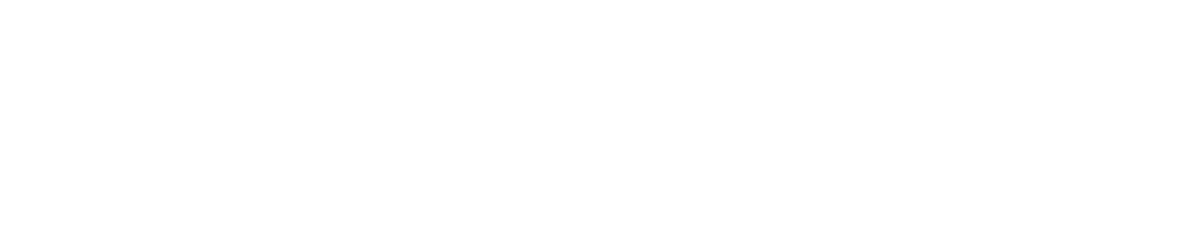

<Figure size 432x288 with 0 Axes>

In [58]:
pl_genes = ["Spock1", "Cacna2d3", "Atp1a3"]
novosparc.pl.embedding(atlas, pl_genes)

## meta data

In [30]:
meta_data_dir = 'data'
meta_ct_path = os.path.join(meta_data_dir, "mouse_brain_meta_ct.csv")

cell_types_raw = pd.read_csv(meta_ct_path)
cell_type = np.asarray(cell_types_raw)

In [32]:
cell_type

array([['Cortex_2'],
       ['Cortex_5'],
       ['Thalamus_2'],
       ...,
       ['Hypothalamus_1'],
       ['Thalamus_2'],
       ['Cortex_4']], dtype=object)

# Reconstruction
## create tissue object

In [48]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


# setup smooth
num_neighbors_s = num_neighbors_t = 5

# alternative 1: setup both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.1
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Setting up for reconstruction ... done ( 17.17 seconds )
Reconstructing spatial information with 49 markers: 2688 cells and 2688 locations ... 
Trying with epsilon: 5.00e-03


/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Trying with epsilon: 5.00e-03


# meta data transfer
## prepare gw matrix

In [49]:
gw_matrix = pd.DataFrame(tissue.gw)
type(gw_matrix)
gw_matrix.shape[0]

2688

# use one-hot encoding

## merge celltype with gw

In [50]:
print(cell_types_raw.shape)
print(gw_matrix.shape)
ct_gw_merge = gw_matrix.join(cell_types_raw)
print(ct_gw_merge.shape)
print(ct_gw_merge[:3])

(2688, 1)
(2688, 2688)
(2688, 2689)
              0             1             2             3             4  \
0  2.701208e-04  3.348031e-08  1.507369e-09  8.653892e-09  5.465680e-08   
1  8.724890e-08  3.303724e-04  9.761795e-10  1.574889e-08  4.071276e-08   
2  1.245076e-08  1.215929e-09  2.445821e-04  2.167522e-09  2.195145e-08   

              5             6             7             8             9  ...  \
0  3.279965e-08  9.199188e-08  1.024672e-07  2.494766e-08  1.655856e-08  ...   
1  6.238084e-09  3.037482e-08  1.572673e-08  9.122858e-09  2.098506e-09  ...   
2  7.151629e-08  3.177913e-08  2.467006e-09  4.125608e-09  1.936125e-07  ...   

           2679          2680          2681          2682          2683  \
0  4.688604e-08  5.440548e-08  5.037407e-09  9.415611e-09  3.446722e-08   
1  1.024142e-08  1.196148e-08  2.130287e-09  5.181170e-09  1.320323e-08   
2  1.411509e-07  1.840865e-07  1.691888e-08  1.086672e-10  2.433456e-08   

           2684          2685          26

## encode cell types

In [51]:
ct_unique = np.unique(cell_type)
print(ct_unique, len(ct_unique))

['Cortex_1' 'Cortex_2' 'Cortex_3' 'Cortex_4' 'Cortex_5' 'Fiber_tract'
 'Hippocampus' 'Hypothalamus_1' 'Hypothalamus_2' 'Lateral_ventricle'
 'Pyramidal_layer' 'Pyramidal_layer_dentate_gyrus' 'Striatum' 'Thalamus_1'
 'Thalamus_2'] 15


In [52]:
onehot = pd.get_dummies(cell_types_raw)

## multiply gw and ct

In [53]:
print(gw_matrix.shape) # cells x locations

ct_gw_merge = np.dot(gw_matrix.T, onehot)
print(ct_gw_merge.shape) # locations x ct

(2688, 2688)
(2688, 15)


## adding the matrix  to the tissue object

In [54]:
ctgw_df = pd.DataFrame(ct_gw_merge, columns=ct_unique)
tissue.ctgw = ctgw_df # celltypes are the columns

# Plotting

1. per celltype visu: 1 color, mapping probability is encoded by alpha value of the color
2. celltype mixture mapping visu: as many colors as celltypes, every location get's the celltype value with the highest probability value

In [55]:
# ToDo

ct_test = ['Hippocampus','Cortex_3', 'Striatum']
dataset_tissue = sc.AnnData(tissue.ctgw, dtype=float)
dataset_tissue.obsm['spatial'] = locations

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


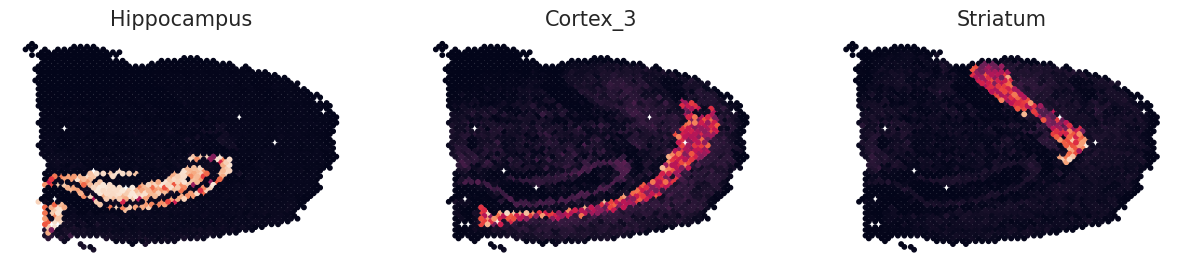

<Figure size 432x288 with 0 Axes>

In [56]:
novosparc.pl.embedding(dataset_tissue, ct_test)

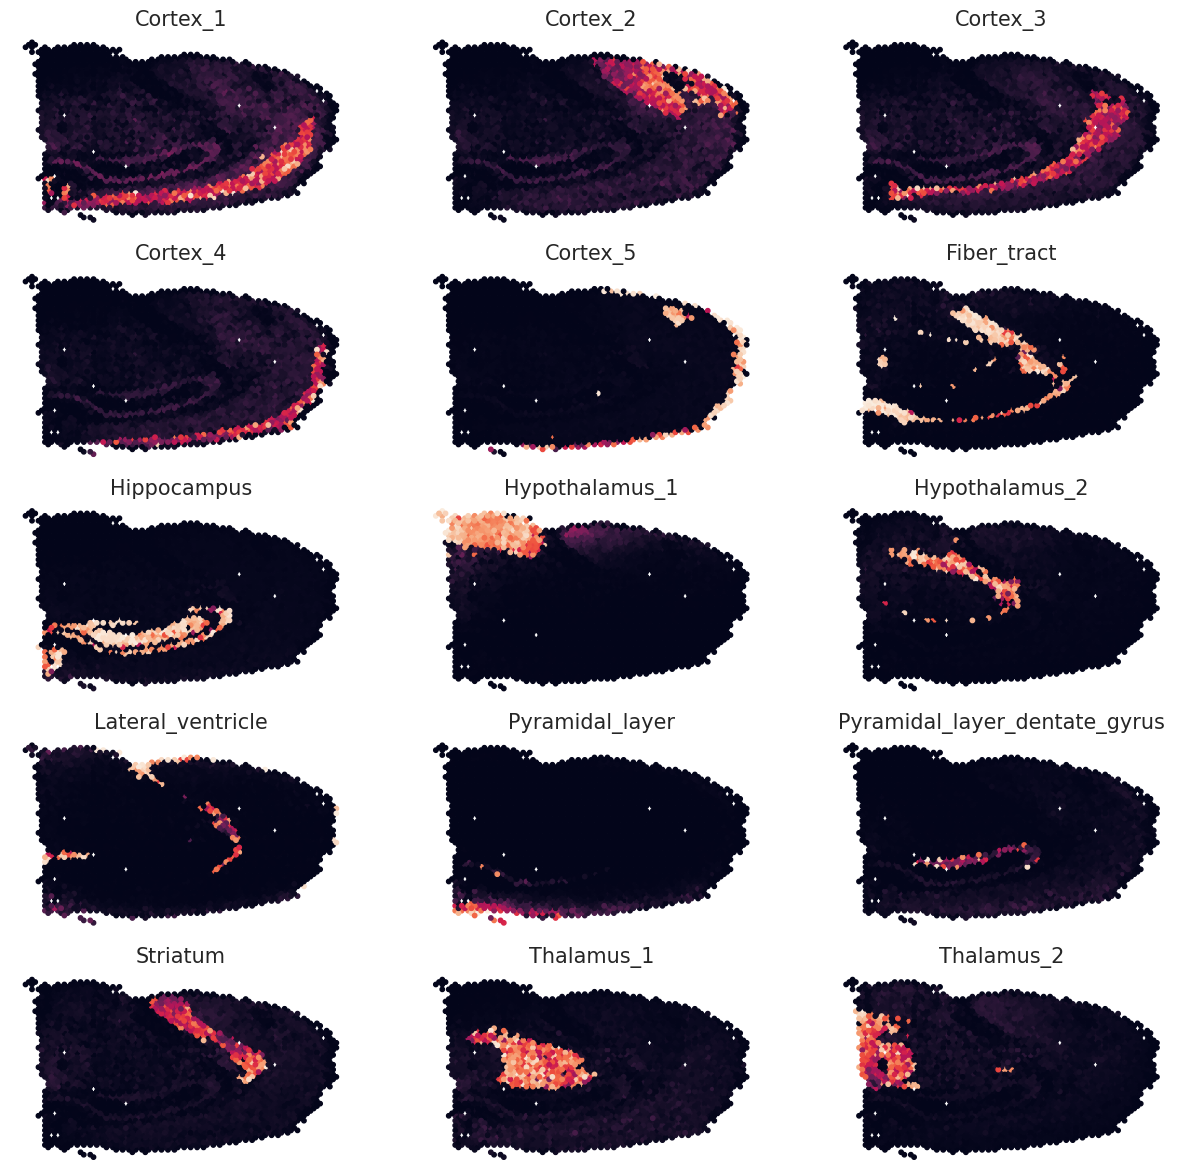

<Figure size 432x288 with 0 Axes>

In [60]:
novosparc.pl.embedding(dataset_tissue, ct_unique)

# check diversity of gw

In [59]:
tissue.gw[0]

array([2.70120766e-04, 3.34803070e-08, 1.50736948e-09, ...,
       2.58308818e-09, 4.78652682e-08, 6.17669900e-08])